In [1]:
import numpy as np
import tensorflow as tf
import math
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import zipfile

data_file = '/content/drive/My Drive/MLData/chest_xray.zip'
output_dir = '/tmp/chest_xray'
zip_ref = zipfile.ZipFile(data_file, 'r')
zip_ref.extractall(output_dir)
zip_ref.close()

In [4]:


train_dir = output_dir + '/chest_xray/train'
val_dir = output_dir + '/chest_xray/val'
test_dir = output_dir + '/chest_xray/test'

print("Training directory : " + train_dir)
print("Validation directory : " + val_dir)
print("Test directory : " + test_dir)

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

img_size = 256

print("\nTraining data :")
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size = (img_size, img_size),
                    batch_size = 32,
                    color_mode = 'grayscale',
                    seed = 7,
                    class_mode = 'binary')

print("Validation data : ")
validation_generator = val_datagen.flow_from_directory(
                          val_dir,
                          target_size = (img_size, img_size),
                          batch_size = 16,
                          color_mode = 'grayscale',
                          class_mode = 'binary')

print("Test data : ")
test_generator = test_datagen.flow_from_directory(
                          test_dir,
                          target_size = (img_size, img_size),
                          batch_size = 16,
                          color_mode = 'grayscale',
                          class_mode = 'binary')

print("Class labels : ")
train_generator.class_indices

Training directory : /tmp/chest_xray/chest_xray/train
Validation directory : /tmp/chest_xray/chest_xray/val
Test directory : /tmp/chest_xray/chest_xray/test

Training data :
Found 5216 images belonging to 2 classes.
Validation data : 
Found 16 images belonging to 2 classes.
Test data : 
Found 624 images belonging to 2 classes.
Class labels : 


{'NORMAL': 0, 'PNEUMONIA': 1}

In [5]:
normal_train_dir = train_dir + "/NORMAL"
pneumonia_train_dir = train_dir + "/PNEUMONIA"

normal_train_files = os.listdir(normal_train_dir)
pneumonia_train_files = os.listdir(pneumonia_train_dir)

print("Normal samples in training data = " + str(len(normal_train_files)))
print("Pneumonia samples in training data = " + str(len(pneumonia_train_files)))
print("Total training samples = " + str(len(normal_train_files) + len(pneumonia_train_files)))

Normal samples in training data = 1342
Pneumonia samples in training data = 3876
Total training samples = 5218


In [0]:
def show_image(image_dir, image_label, max_images):
  print("Showing X-rays of type : " + image_label)
  
  count = 0
  
  files = os.listdir(image_dir)
  for file in files:
    img = load_img(image_dir + "/" + file)
    plt.imshow(img)
    plt.show()
    count = count + 1
    
    if count >= max_images:
      break

Showing normal X-rays:
Showing X-rays of type : NORMAL


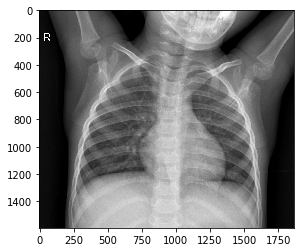

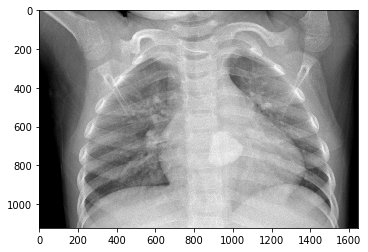

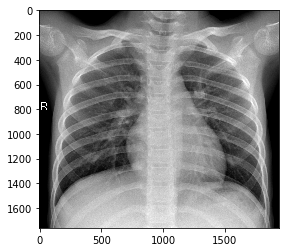

Showing pneumonia X-rays:
Showing X-rays of type : PNEUMONIA


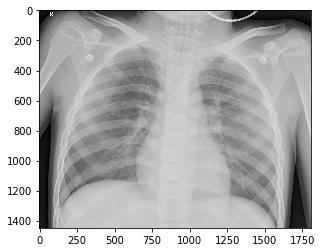

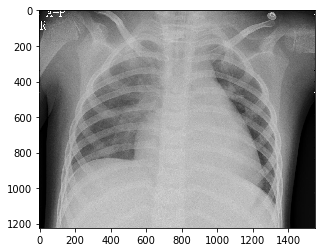

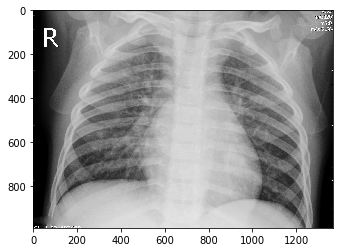

In [8]:

print("Showing normal X-rays:")
show_image(normal_train_dir, "NORMAL", 3)
print("Showing pneumonia X-rays:")
show_image(pneumonia_train_dir, "PNEUMONIA", 3)

In [0]:
def build_model():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu",
                 input_shape = (img_size, img_size, 1)))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(filters=64, kernel_size = (3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(filters=64, kernel_size = (3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  
  return model

In [15]:
xray_model = build_model()
xray_model.summary()

xray_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 57600)             0         
__________

In [16]:
history = xray_model.fit_generator(
          train_generator,
          steps_per_epoch = 5216/32,
          validation_data = test_generator,
          validation_steps = 624/16,
          epochs = 5
          )

Epoch 1/5
163/163 [==============================] - 74s 454ms/step - loss: 0.3662 - acc: 0.8464 - val_loss: 0.3493 - val_acc: 0.8638
Epoch 2/5
163/163 [==============================] - 68s 418ms/step - loss: 0.2083 - acc: 0.9174 - val_loss: 0.3484 - val_acc: 0.8622
Epoch 3/5
163/163 [==============================] - 68s 418ms/step - loss: 0.1774 - acc: 0.9298 - val_loss: 0.3825 - val_acc: 0.8494
Epoch 4/5
163/163 [==============================] - 69s 421ms/step - loss: 0.1687 - acc: 0.9360 - val_loss: 0.2887 - val_acc: 0.9022
Epoch 5/5
163/163 [==============================] - 71s 433ms/step - loss: 0.1514 - acc: 0.9484 - val_loss: 0.2271 - val_acc: 0.9183


Text(0.5, 1.0, 'Loss')

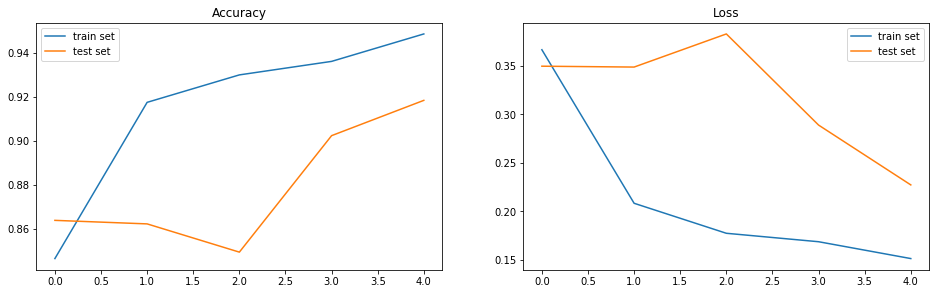

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs  = range(0, len(acc))

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222 )

ax1.plot(acc, label = 'train set')
ax1.plot(val_acc, label = 'test set')
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(loss, label = 'train set')
ax2.plot(val_loss, label= 'test set')
ax2.legend()
ax2.set_title('Loss')

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)